In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load your data
df = pd.read_csv("cases_engineered.csv")
print(f"Dataset shape: {df.shape}")

In [15]:
# Convert dates
date_cols = ['date_of_filing', 'date_first_list']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

# Take 1% random sample
sample_size = 0.01
df_sample = df.sample(frac=sample_size, random_state=42)

print(f"Original size: {len(df):,} cases")
print(f"Sample size: {len(df_sample):,} cases ({sample_size*100:.1f}%)")
print(f"Sample represents {len(df_sample)/len(df)*100:.2f}% of data")

Original size: 36,480,733 cases
Sample size: 364,807 cases (1.0%)
Sample represents 1.00% of data


In [16]:
print(f"\n=== K-NEAREST NEIGHBORS MODEL FOR CASE DURATION PREDICTION ===")
print(f"Sample size: {len(df_sample):,} cases ({sample_size*100:.1f}% of data)")

# Define feature sets
raw_features = [
    'act', 'section', 'bailable_ipc', 'number_sections_ipc', 
    'criminal', 'female_defendant', 'female_petitioner', 
    'type_name', 'court_details', 'state_district'
]

engineered_features = [
    'judge_category', 'filing_year', 'filing_month', 'filing_quarter',
    'filing_dayofweek', 'filing_dayofyear', 'filing_weekofyear',
    'first_list_delay', 'first_list_month', 'first_list_quarter',
    'filed_on_weekend', 'first_list_on_weekend'
]

# Check which features exist
available_features = []
for feature_list in [raw_features, engineered_features]:
    for feature in feature_list:
        if feature in df_sample.columns:
            available_features.append(feature)

print(f"\nAvailable features for modeling: {len(available_features)}")
print(f"Features: {available_features}")

# Prepare X and y
X = df_sample[available_features].copy()
y = df_sample['case_duration_days']

print(f"\nTarget variable 'case_duration_days' statistics:")
print(f"  Mean: {y.mean():.2f} ± {y.std():.2f} days")
print(f"  Range: {y.min():.2f} to {y.max():.2f} days")
print(f"  NaN values: {y.isna().sum()}")

# Remove NaN in target
mask = y.notna()
X = X[mask]
y = y[mask]

print(f"\nFinal dataset shape: X={X.shape}, y={y.shape}")

# Check data types
print(f"\nData types:")
print(X.dtypes.value_counts())

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"\nFound categorical columns: {list(categorical_cols)}")
    print("Converting categorical columns to numeric codes...")
    
    # Simple encoding for categorical variables
    for col in categorical_cols:
        # Use pandas factorize to convert strings to numeric codes
        X[col], _ = pd.factorize(X[col])
        print(f"  Encoded {col}: {X[col].nunique()} unique values")
    
    # Convert to float for scaling
    X = X.astype(float)

# Check for any remaining non-numeric columns
non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print(f"\nWarning: Still have non-numeric columns: {list(non_numeric_cols)}")
    print("Dropping these columns...")
    X = X.drop(columns=non_numeric_cols)

# Handle any remaining NaN values
print(f"\nHandling missing values...")
nan_counts = X.isna().sum()
if nan_counts.any():
    print(f"Found NaN values in columns:")
    for col in nan_counts[nan_counts > 0].index:
        print(f"  {col}: {nan_counts[col]} NaN values")
        # Fill with median for numerical columns
        X[col] = X[col].fillna(X[col].median())
else:
    print("No NaN values found in features")

# CRITICAL FOR KNN: Scale features
print("\n=== FEATURE SCALING (Critical for KNN) ===")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")

# Train KNN model
print("\n=== TRAINING K-NEAREST NEIGHBORS MODEL ===")
print("Note: KNN is computationally intensive but simple and interpretable")

# Start with a simple KNN model
start_time = time.time()

# For faster training, we'll start with a reasonable k
# You can adjust these parameters based on your needs
knn = KNeighborsRegressor(
    n_neighbors=50,  # Start with 50 neighbors
    weights='distance',  # Closer neighbors have more influence
    algorithm='auto',  # Let sklearn choose best algorithm
    leaf_size=30,
    p=2,  # Euclidean distance
    metric='minkowski',
    n_jobs=-1  # Use all CPU cores
)

print("Training KNN model...")
knn.fit(X_train, y_train)
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Evaluate
print("\nMaking predictions...")
start_time = time.time()
y_pred = knn.predict(X_test)
prediction_time = time.time() - start_time
print(f"Prediction time for {len(X_test)} samples: {prediction_time:.2f} seconds")

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Baseline (predicting mean)
baseline_pred = [y.mean()] * len(y_test)
baseline_mae = mean_absolute_error(y_test, baseline_pred)

print(f"\n=== KNN MODEL PERFORMANCE ===")
print(f"Mean Absolute Error (MAE): {mae:.2f} days")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"Mean actual duration: {y.mean():.2f} days")
print(f"Std actual duration: {y.std():.2f} days")
print(f"\nBaseline (predicting mean):")
print(f"  MAE: {baseline_mae:.2f} days")
print(f"  KNN improvement over baseline: {(1 - mae/baseline_mae)*100:.1f}%")

# Analyze prediction errors
errors = y_test.values - y_pred
abs_errors = np.abs(errors)

print(f"\n=== ERROR ANALYSIS ===")
print(f"Mean absolute error: {abs_errors.mean():.2f} days")
print(f"Std of errors: {errors.std():.2f} days")
print(f"Percentage of predictions within:")
for threshold in [30, 90, 180, 365]:
    within_threshold = (abs_errors <= threshold).mean() * 100
    print(f"  ±{threshold} days: {within_threshold:.1f}%")

# Compare with simple heuristic
print(f"\n=== COMPARISON WITH HEURISTICS ===")
# Heuristic 1: Assume all cases take median time
median_pred = [y.median()] * len(y_test)
median_mae = mean_absolute_error(y_test, median_pred)
print(f"Predicting median ({y.median():.1f} days): MAE = {median_mae:.2f} days")
print(f"KNN beats median prediction by: {(1 - mae/median_mae)*100:.1f}%")

# Heuristic 2: Days to first list * multiplier
if 'first_list_delay' in df_sample.columns:
    # Get the indices for X_test in the original dataframe
    test_indices = y_test.index
    heuristic_pred = df_sample.loc[test_indices, 'first_list_delay'] * 3
    heuristic_mae = mean_absolute_error(y_test, heuristic_pred)
    print(f"Heuristic (3× days to first list): MAE = {heuristic_mae:.2f} days")
    print(f"KNN beats heuristic by: {(1 - mae/heuristic_mae)*100:.1f}%")

# Check prediction distribution
print(f"\n=== PREDICTION DISTRIBUTION ===")
print(f"Actual duration range: {y.min():.1f} to {y.max():.1f} days")
print(f"Predicted duration range: {y_pred.min():.1f} to {y_pred.max():.1f} days")
print(f"Mean predicted: {y_pred.mean():.1f} days")
print(f"Mean actual (test set): {y_test.mean():.1f} days")

# Performance comparison with Random Forest baseline
print(f"\n=== COMPARISON WITH RANDOM FOREST BASELINE ===")
print(f"Previous Random Forest R² with raw features: 0.46")
print(f"Current KNN R² with engineered features: {r2:.4f}")
if r2 > 0.46:
    improvement = r2 - 0.46
    print(f"Improvement in R²: +{improvement:.4f}")
    print(f"Percentage improvement: {improvement/0.46*100:.1f}%")
else:
    print(f"Performance difference: {r2 - 0.46:.4f}")

# Analyze nearest neighbors
print(f"\n=== KNN MODEL ANALYSIS ===")
print(f"Number of neighbors (k): {knn.n_neighbors}")
print(f"Distance metric: {knn.metric}")
print(f"Weighting: {knn.weights}")

# Save predictions for analysis
predictions_df = pd.DataFrame({
    'actual_duration': y_test.values,
    'predicted_duration': y_pred,
    'error': errors,
    'abs_error': abs_errors
})

print(f"\n=== PREDICTION QUALITY BY ERROR RANGE ===")
error_bins = [0, 30, 90, 180, 365, float('inf')]
error_labels = ['<30 days', '30-90 days', '90-180 days', '180-365 days', '>365 days']

predictions_df['error_range'] = pd.cut(predictions_df['abs_error'], bins=error_bins, labels=error_labels)
error_distribution = predictions_df['error_range'].value_counts().sort_index()

for range_label, count in error_distribution.items():
    percentage = count / len(predictions_df) * 100
    print(f"  {range_label}: {count:,} cases ({percentage:.1f}%)")

# Feature importance for KNN (approximation)
print(f"\n=== FEATURE IMPORTANCE ANALYSIS FOR KNN ===")
print("Note: KNN doesn't provide direct feature importance like Random Forest")

# Quick variance-based importance (after scaling)
print("\nFeature statistics (after scaling):")
feature_stats = pd.DataFrame({
    'feature': available_features[:X.shape[1]],  # Only include features that survived processing
    'mean': np.mean(X_scaled, axis=0),
    'std': np.std(X_scaled, axis=0),
    'variance': np.var(X_scaled, axis=0)
}).sort_values('variance', ascending=False)

print("\nTop 10 features by variance (high variance may indicate importance):")
for i, row in feature_stats.head(10).iterrows():
    print(f"  {row['feature']:25s} : Mean={row['mean']:.2f}, Std={row['std']:.2f}, Variance={row['variance']:.2f}")

print("\n=== RECOMMENDATIONS ===")
print("1. For better KNN performance:")
print("   - Try different k values (5, 10, 20, 50, 100)")
print("   - Experiment with distance metrics (Manhattan vs Euclidean)")
print("   - Consider feature selection to reduce dimensionality")
print("\n2. KNN vs Random Forest comparison:")
print("   - Random Forest: Better with many features, handles non-linear relationships well")
print("   - KNN: Simple, interpretable, good for local patterns")
print("   - Consider ensemble of both models")
print("\n3. For production use:")
print("   - Random Forest is usually faster at prediction time")
print("   - KNN requires storing all training data")
print("   - Consider dimensionality reduction for KNN")

print("\n=== KNN MODEL TRAINING COMPLETE ===")


=== K-NEAREST NEIGHBORS MODEL FOR CASE DURATION PREDICTION ===
Sample size: 364,807 cases (1.0% of data)

Available features for modeling: 22
Features: ['act', 'section', 'bailable_ipc', 'number_sections_ipc', 'criminal', 'female_defendant', 'female_petitioner', 'type_name', 'court_details', 'state_district', 'judge_category', 'filing_year', 'filing_month', 'filing_quarter', 'filing_dayofweek', 'filing_dayofyear', 'filing_weekofyear', 'first_list_delay', 'first_list_month', 'first_list_quarter', 'filed_on_weekend', 'first_list_on_weekend']

Target variable 'case_duration_days' statistics:
  Mean: 562.55 ± 570.06 days
  Range: 0.00 to 33283.00 days
  NaN values: 0

Final dataset shape: X=(364807, 22), y=(364807,)

Data types:
int64      13
float64     4
object      4
int32       1
Name: count, dtype: int64

Found categorical columns: ['bailable_ipc', 'court_details', 'state_district', 'judge_category']
Converting categorical columns to numeric codes...
  Encoded bailable_ipc: 6 unique 

5-Bin Classification Performance:
Accuracy: 0.6775594788847447
Precision (weighted): 0.7741410486869199
Recall (weighted): 0.6775594788847447
F1 Score (weighted): 0.6844173379112266

Classification Report:

              precision    recall  f1-score   support

     <1 year       0.94      0.70      0.80   1130119
   1–3 years       0.46      0.88      0.61    595506
    >3 years       0.77      0.37      0.50    463219

    accuracy                           0.68   2188844
   macro avg       0.72      0.65      0.64   2188844
weighted avg       0.77      0.68      0.68   2188844



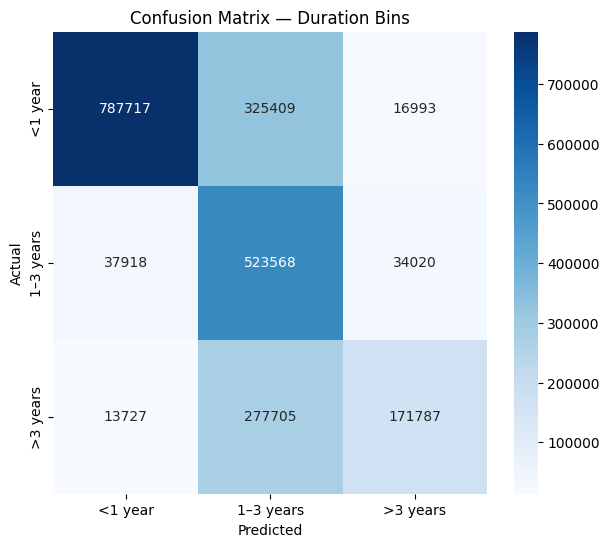

In [6]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Define the 5-bin classifier function
# ------------------------------------------------------
def duration_to_class_5bins(x):
    if x < 365:
        return 0   # < 1 year
    elif x < 1095:
        return 1   # 1 to <3 years
    else :
        return 2   # >3 years
    

class_names = [
    "<1 year",
    "1–3 years",
    ">3 years"
]

# ------------------------------------------------------
# 2. Prepare true and predicted durations
#    (if you trained on log1p, do inverse transform)
# ------------------------------------------------------

y_test_true = np.array(y_test)        # or np.expm1(y_test_log)
y_pred_true = np.array(y_pred)        # or np.expm1(y_pred_log)

# ------------------------------------------------------
# 3. Convert durations → classes
# ------------------------------------------------------

y_test_cls = np.vectorize(duration_to_class_5bins)(y_test_true)
y_pred_cls = np.vectorize(duration_to_class_5bins)(y_pred_true)

# ------------------------------------------------------
# 4. Compute classification metrics
# ------------------------------------------------------

accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
recall = recall_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
f1 = f1_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)

print("5-Bin Classification Performance:")
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

# ------------------------------------------------------
# 5. Detailed Classification Report
# ------------------------------------------------------

print("\nClassification Report:\n")
print(classification_report(y_test_cls, y_pred_cls, target_names=class_names, zero_division=0))

# ------------------------------------------------------
# 6. Confusion Matrix
# ------------------------------------------------------

cm = confusion_matrix(y_test_cls, y_pred_cls, labels=[0,1,2])
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix — Duration Bins")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


5-Bin Classification Performance:
Accuracy: 0.6775594788847447
Precision (weighted): 0.7741410486869199
Recall (weighted): 0.6775594788847447
F1 Score (weighted): 0.6844173379112266

Classification Report:

              precision    recall  f1-score   support

     <1 year       0.94      0.70      0.80   1130119
   1–3 years       0.46      0.88      0.61    595506
    >3 years       0.77      0.37      0.50    463219

    accuracy                           0.68   2188844
   macro avg       0.72      0.65      0.64   2188844
weighted avg       0.77      0.68      0.68   2188844



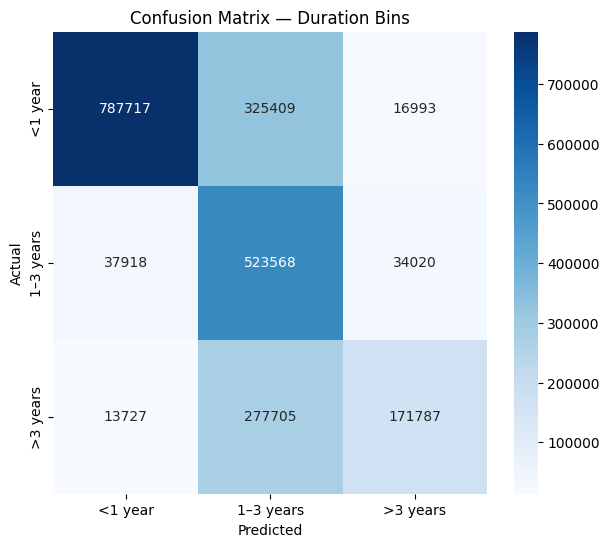

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------
# 1. Define the 5-bin classifier function
# ------------------------------------------------------
def duration_to_class_5bins(x):
    if x < 365:
        return 0   # < 1 year
    elif x < 1095:
        return 1   # 1 to <3 years
    else :
        return 2   # >3 years
    

class_names = [
    "<1 year",
    "1–3 years",
    ">3 years"
]

# ------------------------------------------------------
# 2. Prepare true and predicted durations
#    (if you trained on log1p, do inverse transform)
# ------------------------------------------------------

y_test_true = np.array(y_test)        # or np.expm1(y_test_log)
y_pred_true = np.array(y_pred)        # or np.expm1(y_pred_log)

# ------------------------------------------------------
# 3. Convert durations → classes
# ------------------------------------------------------

y_test_cls = np.vectorize(duration_to_class_5bins)(y_test_true)
y_pred_cls = np.vectorize(duration_to_class_5bins)(y_pred_true)

# ------------------------------------------------------
# 4. Compute classification metrics
# ------------------------------------------------------

accuracy = accuracy_score(y_test_cls, y_pred_cls)
precision = precision_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
recall = recall_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)
f1 = f1_score(y_test_cls, y_pred_cls, average="weighted", zero_division=0)

print("5-Bin Classification Performance:")
print("Accuracy:", accuracy)
print("Precision (weighted):", precision)
print("Recall (weighted):", recall)
print("F1 Score (weighted):", f1)

# ------------------------------------------------------
# 5. Detailed Classification Report
# ------------------------------------------------------

print("\nClassification Report:\n")
print(classification_report(y_test_cls, y_pred_cls, target_names=class_names, zero_division=0))

# ------------------------------------------------------
# 6. Confusion Matrix
# ------------------------------------------------------

cm = confusion_matrix(y_test_cls, y_pred_cls, labels=[0,1,2])
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix — Duration Bins")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
